## Import Packages

In [2]:
from __future__ import absolute_import, division, print_function

import pprint
import argparse
import logging
import os
import random
import sys
import pickle
import copy
import collections
import math

import numpy as np
import numpy
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler,TensorDataset

from torch.nn import CrossEntropyLoss, MSELoss

from transformer import BertForSequenceClassification,WEIGHTS_NAME, CONFIG_NAME
from transformer.modeling_quant import BertForSequenceClassification as QuantBertForSequenceClassification
from transformer import BertTokenizer
from transformer import BertAdam
from transformer import BertConfig
from transformer import QuantizeLinear, BertSelfAttention, FP_BertSelfAttention, BertAttention, FP_BertAttention
from utils_glue import *

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn.functional as F

mse_func = MSELoss()

processors = {
    "cola": ColaProcessor,
    "mnli": MnliProcessor,
    "mnli-mm": MnliMismatchedProcessor,
    "mrpc": MrpcProcessor,
    "sst-2": Sst2Processor,
    "sts-b": StsbProcessor,
    "qqp": QqpProcessor,
    "qnli": QnliProcessor,
    "rte": RteProcessor   
}

output_modes = {
        "cola": "classification",
        "mnli": "classification",
        "mrpc": "classification",
        "sst-2": "classification",
        "sts-b": "regression",
        "qqp": "classification",
        "qnli": "classification",
        "rte": "classification"
}

default_params = {
        "cola": {"max_seq_length": 64,"batch_size":1,"eval_step": 50}, # No Aug : 50 Aug : 400
        "mnli": {"max_seq_length": 128,"batch_size":1,"eval_step":8000},
        "mrpc": {"max_seq_length": 128,"batch_size":1,"eval_step":100},
        "sst-2": {"max_seq_length": 64,"batch_size":1,"eval_step":100},
        "sts-b": {"max_seq_length": 128,"batch_size":1,"eval_step":100},
        "qqp": {"max_seq_length": 128,"batch_size":1,"eval_step":1000},
        "qnli": {"max_seq_length": 128,"batch_size":1,"eval_step":1000},
        "rte": {"max_seq_length": 128,"batch_size":1,"eval_step": 20}
    }

def get_tensor_data(output_mode, features):
    if output_mode == "classification":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)


    all_seq_lengths = torch.tensor([f.seq_length for f in features], dtype=torch.long)
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    tensor_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,all_label_ids, all_seq_lengths)
    return tensor_data, all_label_ids

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0 
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


11/11 09:05:50 AM Note: detected 78 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
11/11 09:05:50 AM Note: NumExpr detected 78 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)

## Dataset & Model Setting

In [8]:
task_name = "sst-2"
bert_size = "large"

if bert_size == "large":
    layer_num = 24
    head_num = 16
else: 
    layer_num = 12
    head_num = 12

model_dir = "models/BERT_large/sst-2"

# Prepare Dataset

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Processor & Task Info
processor = processors[task_name]()
output_mode = output_modes[task_name]
label_list = processor.get_labels()
num_labels = len(label_list)

if task_name in default_params:
    batch_size = default_params[task_name]["batch_size"]
    max_seq_length = default_params[task_name]["max_seq_length"]
    eval_step = default_params[task_name]["eval_step"]
    
# Tokenizer
tokenizer = BertTokenizer.from_pretrained(model_dir, do_lower_case=True)

# Load Dataset
data_dir = os.path.join("data",task_name)

eval_examples = processor.get_dev_examples(data_dir)
eval_features = convert_examples_to_features(eval_examples, label_list, max_seq_length, tokenizer, output_mode)

eval_data, eval_labels = get_tensor_data("classification", eval_features)
eval_sampler = RandomSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=1)
eval_data, eval_labels = get_tensor_data(output_mode, eval_features)

# Get input batch sample
batch = next(iter(eval_dataloader))
input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch
seq_length = seq_lengths[0]

input_ids_sliced = input_ids[:,:seq_length]

11/11 09:07:54 AM Writing example 0 of 872
11/11 09:07:54 AM *** Example ***
11/11 09:07:54 AM guid: dev-1
11/11 09:07:54 AM tokens: [CLS] it ' s a charming and often affecting journey . [SEP]
11/11 09:07:54 AM input_ids: 101 2009 1005 1055 1037 11951 1998 2411 12473 4990 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
11/11 09:07:54 AM input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
11/11 09:07:54 AM segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
11/11 09:07:54 AM label: 1
11/11 09:07:54 AM label_id: 1


# Build Model

In [17]:
# Build Model
teacher_model_dir = "models/BERT_large/sst-2"
teacher_model = BertForSequenceClassification.from_pretrained(teacher_model_dir, num_labels=num_labels)
print("Teacher Model - FP Fine-Tuned Model")

# Attenion-Map QAT model
student_model_M_dir = "output/BERT_large/sst-2/exploration/sst-2_large_map_large_M_42"
student_config = BertConfig.from_pretrained(student_model_M_dir)             
student_model_M = QuantBertForSequenceClassification.from_pretrained(student_model_M_dir, config = student_config, num_labels=num_labels)
print("Student Model - Attention Map KD-QAT")

# Attenion-Output QAT model
student_model_O_dir = "output/BERT_large/sst-2/exploration/sst-2_large_output_large_O_42"
student_config = BertConfig.from_pretrained(student_model_O_dir)             
student_model_O = QuantBertForSequenceClassification.from_pretrained(student_model_O_dir, config = student_config, num_labels=num_labels)
print("Student Model - Attention Output KD-QAT")

# Quantized model w/o QAT
teacher_model_dir = "models/BERT_large/sst-2"
student_config = BertConfig.from_pretrained(student_model_O_dir)      
student_model_Q = QuantBertForSequenceClassification.from_pretrained(teacher_model_dir, config = student_config, num_labels=num_labels)
print("Student Model - Quantized w/o Q")


Teacher Model - FP Fine-Tuned Model
Student Model - Attention Map KD-QAT
Student Model - Attention Output KD-QAT


# Self-Attention Map Distance Analysis (Figure. 4)


In [25]:
# Model Inference
teacher_outputs = teacher_model(input_ids_sliced)
student_outputs_M  = student_model_M(input_ids_sliced)
student_outputs_O  = student_model_O(input_ids_sliced)
student_outputs_Q  = student_model_Q(input_ids_sliced)

_, _, _, teacher_probs, _ = teacher_outputs
_, _, _, student_probs_M, _ = student_outputs_M
_, _, _, student_probs_O, _ = student_outputs_O
_, _, _, student_probs_Q, _ = student_outputs_Q

## 1. Ranking Loss

In [26]:
# Liu et al, Post-Training Quantization for Vision Transformer, NeurIPS2021, https://arxiv.org/abs/2106.14156 
def ranking_loss_func(student_probs, teacher_probs):
    Loss_ranking = 0

    loss_ranking_list = []

    for l in tqdm(range(layer_num)):
        for h in range(head_num):
            student_prob_plt = student_probs[l][0,h,:,:]
            teacher_prob_plt = teacher_probs[l][0,h,:,:]
            Loss_ranking = 0
            for h in range(seq_length):
                for idx in range(0, seq_length-1):
                    for jdx in range(1, seq_length):
                        p = (student_prob_plt[h][idx] - student_prob_plt[h][jdx])*(torch.sgn(teacher_prob_plt[h][idx] - teacher_prob_plt[h][jdx]))
                        Loss_ranking += max(0,  - p.item())
            loss_ranking_list.append(Loss_ranking)
    return loss_ranking_list

In [27]:
ranking_M = ranking_loss_func(student_probs_M, teacher_probs)
ranking_O = ranking_loss_func(student_probs_O, teacher_probs)
ranking_Q = ranking_loss_func(student_probs_Q, teacher_probs)


100% 24/24 [01:01<00:00,  2.57s/it]
100% 24/24 [01:02<00:00,  2.60s/it]
100% 24/24 [01:03<00:00,  2.66s/it]


In [99]:
ranking_losses = (ranking_M, ranking_O, ranking_Q)
torch.save(ranking_losses, f"analysis_outputs/{bert_size}_{task_name}_SA_ranking_loss.pth")

## Plot Ranking Loss Graph per Attention-Head

Text(0, 0.5, 'Ranking Loss(CoLA)')

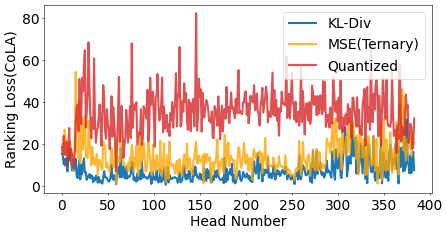

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=50)
fs=20
lw=3
ax.plot(list(range(layer_num*head_num)), ranking_M, label="KL-Div", color="tab:blue", linewidth=lw, alpha=1)
ax.plot(list(range(layer_num*head_num)), ranking_O, label="MSE(Ternary)", color="orange", linewidth=lw, alpha=0.8)
ax.plot(list(range(layer_num*head_num)), ranking_Q, label="Quantized", color="tab:red", linewidth=lw, alpha=0.8)

ax.set_title("Per Head Ranking Loss Comparison")
ax.legend(fontsize=fs, loc=1)
ax.tick_params(labelsize = fs)
ax.set_xlabel("Head Number", fontsize=fs)
ax.set_ylabel(f"Ranking Loss(CoLA)", fontsize=fs)

## 2. Cover Length Ratio

In [34]:
def cover_length_ratio_func(student_probs, teacher_probs):
    top_k = 5 # you can set the top-k number according to the task's max sequence length
    cover_length_ratio_list = []
    
    for l in tqdm(range(layer_num)):
        
        teacher = teacher_probs[l][0]
        student = student_probs[l][0]

        head_sum = 0
        for h in range(head_num):
            coverage_head_sum = 0
            for row in range(seq_length-1):
                # Sort Attention Probability in Self-Attention Map
                tc_argsort = teacher[h].sort(descending=True)[1][row][:top_k] # top-k
                st_argsort = student[h].sort(descending=True)[1][row]

                max_idx = 0
                # Find the last index that cover teacher's top_k tokens
                for idx in tc_argsort:
                    tmp = torch.where(st_argsort == idx)
                    max_idx = max(tmp[0].item(), max_idx)
                
                coverage_ratio = max_idx / student.shape[1]
                coverage_head_sum += coverage_ratio
                
            cover_length_ratio_list.append(coverage_head_sum / seq_length)
    return cover_length_ratio_list

In [41]:
coverage_M = cover_length_ratio_func(student_probs_M, teacher_probs)
coverage_O = cover_length_ratio_func(student_probs_O, teacher_probs)
coverage_Q = cover_length_ratio_func(student_probs_Q, teacher_probs)

100% 24/24 [00:00<00:00, 34.76it/s]
100% 24/24 [00:00<00:00, 34.35it/s]
100% 24/24 [00:00<00:00, 35.16it/s]


In [42]:
ranking_losses = (coverage_M, coverage_O, coverage_Q)
torch.save(ranking_losses, f"analysis_outputs/{bert_size}_{task_name}_SA_cover_length_ratio.pth")

Text(0, 0.5, 'Cover Length Ratio')

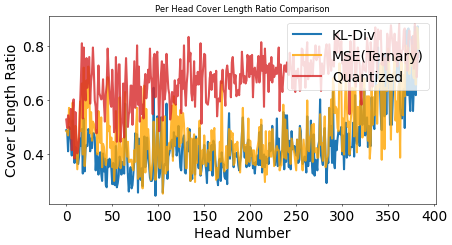

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=50)
fs=20
lw=3
ax.plot(list(range(layer_num*head_num)), coverage_M, label="KL-Div", color="tab:blue", linewidth=lw, alpha=1)
ax.plot(list(range(layer_num*head_num)), coverage_O, label="MSE(Ternary)", color="orange", linewidth=lw, alpha=0.8)
ax.plot(list(range(layer_num*head_num)), coverage_Q, label="Quantized", color="tab:red", linewidth=lw, alpha=0.8)

ax.set_title("Per Head Cover Length Ratio Comparison")
ax.legend(fontsize=fs, loc=1)
ax.tick_params(labelsize = fs)
ax.set_xlabel("Head Number", fontsize=fs)
ax.set_ylabel(f"Cover Length Ratio", fontsize=fs)